In [4]:
from find_source import full_html_and_txt, make_catalog, summary
import glob
import json

In [2]:
#summary('../data/250611_03:56:34/3c279_full.fits')

../data/250611_03:56:34/1310+323_lr_full.fits: {'int_peak_val': 0.7811602354049683, 'int_peak_coord': (-0.19373208400098826, -0.19373208400098826), 'int_snr': 68.69620215427587, 'calc_int_snr': 48.280056726550306, 'int_prob': 0.0, 'calc_int_prob': 0.0, 'ext_peak_val': [0.10361447185277939, 0.10345692187547684, 0.06213110685348511], 'ext_peak_coord': [(-6.005694604030636, -2.5185170920128472), (-5.61823043602866, -5.61823043602866), (5.2307662680266835, 5.424498352027672)], 'ext_snr': [9.021296401558613, 9.036541505802498, 5.452629842767915], 'calc_ext_snr': 3.5370275139526597, 'ext_prob': [8.647462616340701e-16, 7.553034837033257e-16, 0.00013359948540455377], 'calc_ext_prob': 0.9999999999999966, 'field_center': (0, 0), 'rms': 0.011371228843927383, 'calc_rms_val': 0.016179770455310803, 'n_incl_meas': 113.1426010197971, 'n_excl_meas': 4942.451233960248, 'radius': [6.44419112, 1.4441911199999997, 1.4441911199999997, 1.4441911199999997]}
../data/250611_03:56:34/1635+381_full.fits: {'int_pe

<Figure size 384x288 with 0 Axes>

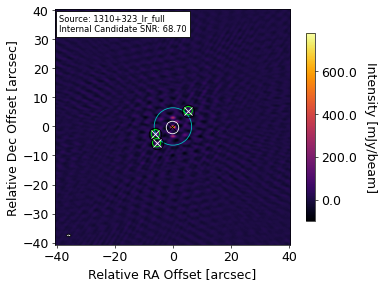

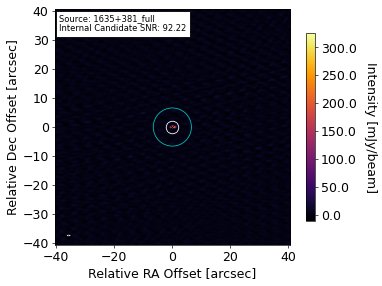

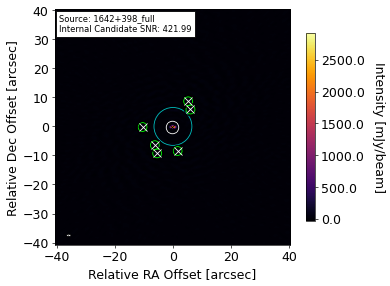

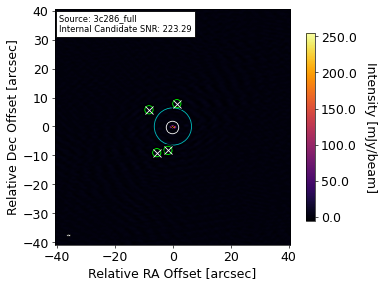

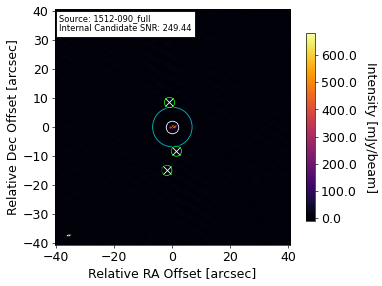

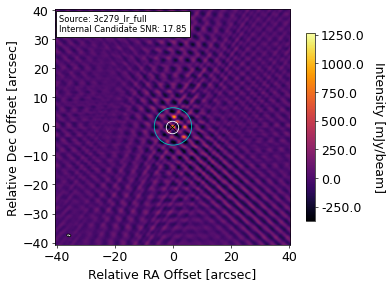

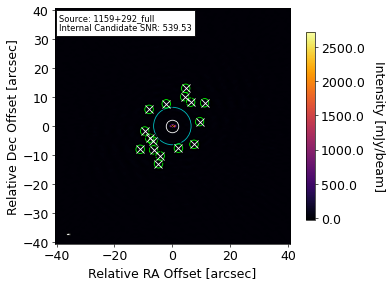

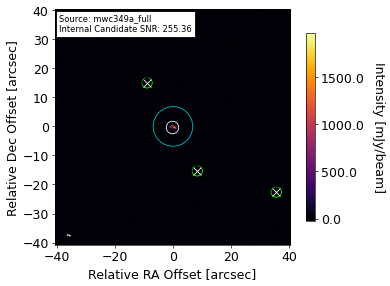

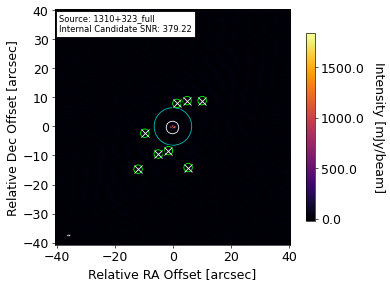

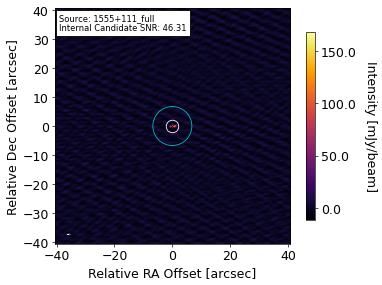

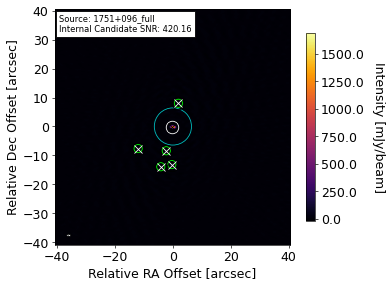

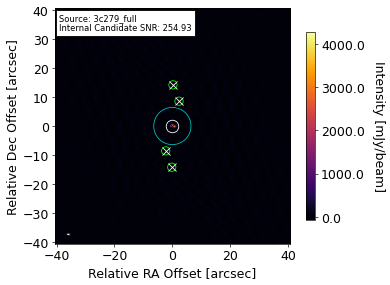

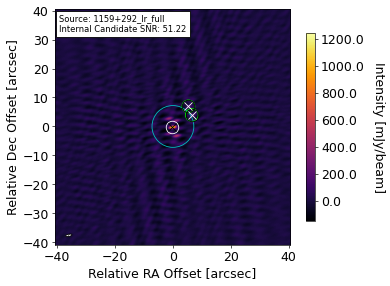

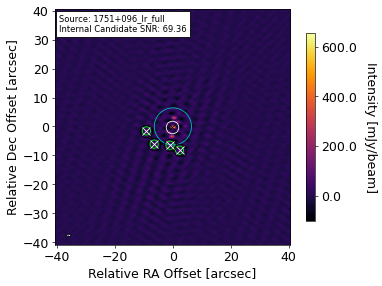

In [5]:
for file in glob.glob('../data/250611_03:56:34/*.fits'):
    try:
        print(f'{file}: {summary(file)}')
    except KeyError:
        pass

In [2]:
#%%timeit
full_html_and_txt('../data/250611_03:56:34')

In [ ]:
folders = []
for folder in glob.glob('/reduction/karto/SMA/polaris_test/*'):
    print(folder)
    folders.append(folder)

/reduction/karto/SMA/polaris_test/250101_04:01:33
/reduction/karto/SMA/polaris_test/run_polaris.m
/reduction/karto/SMA/polaris_test/250101_14:31:46
/reduction/karto/SMA/polaris_test/250102_03:39:23
/reduction/karto/SMA/polaris_test/250103_05:25:18
/reduction/karto/SMA/polaris_test/250104_03:18:27
/reduction/karto/SMA/polaris_test/250105_04:05:43
/reduction/karto/SMA/polaris_test/250106_03:59:50
/reduction/karto/SMA/polaris_test/250106_13:01:37
/reduction/karto/SMA/polaris_test/250106_15:00:08
/reduction/karto/SMA/polaris_test/250106_17:38:06
/reduction/karto/SMA/polaris_test/250107_03:21:27
/reduction/karto/SMA/polaris_test/250107_11:09:13
/reduction/karto/SMA/polaris_test/250108_04:00:57
/reduction/karto/SMA/polaris_test/250109_03:31:04
/reduction/karto/SMA/polaris_test/250109_07:40:11
/reduction/karto/SMA/polaris_test/250109_15:20:50
/reduction/karto/SMA/polaris_test/250111_03:59:34
/reduction/karto/SMA/polaris_test/250112_04:00:37
/reduction/karto/SMA/polaris_test/250114_03:31:47
/r

In [72]:
full_html_and_txt(folders[0])
print(folders[0])
folders = folders[1:]

/reduction/karto/SMA/polaris_test/250212_17:03:29
